# Temporal Fourier Analysis

The Fourier transform converts a signal in the time domain to the frequency domain. This is useful to reconstruct long-term trends in climate data, since we can easily discard low-amplitude, high-frequency noise in transformed data and then convert back to the time domain. If the signal is lossy, we can also use the underlying harmonics to reconstruct the signal. 

Climate data do not have enough harmonics to warrant the full Fourier transformation. [Shiff et al. (2021)](https://www.nature.com/articles/s41597-021-00861-7) demonstrate the the three first harmonics are sufficient to accurate reconstruct MODIS land surface temperature data. The underlying mathematics are described in [Scharlemann et al. (2008)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0001408).

The Fourier series of a signal $x$ with $N$ samples is:
$$
x_t = a_0 + \sum_{p=1}^{N/2-1} a_p \cos{\frac{2\pi p t}{N}} + b_p \sin{\frac{2\pi p t}{N}} + a_{N/2} \cos{\pi t}
$$

where:

$$
\begin{align}
a_0 &= \bar{x} \newline
a_p &= \frac{2(\sum{x_t \cos(2\pi p t / N)})}{N} \newline
b_p &= \frac{2(\sum{x_t \sin(2\pi p t / N)})}{N} \newline
p &= 1, \ldots, N/2 
\end{align}
$$

$a_p$ and $b_p$ can be combined into one harmonic:

$$
a_p \cos{\frac{2\pi p t}{N}} + b_p \sin{\frac{2\pi p t}{N}} = R_p\cos{\frac{2 \pi p t}{N} + \phi_p}
$$

where:

$$
\begin{align}
R_p &= \sqrt{a_p^2 + b_p^2} \newline
\phi_p &= \arctan{\frac{-b_p}{a_p}}
\end{align}
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt

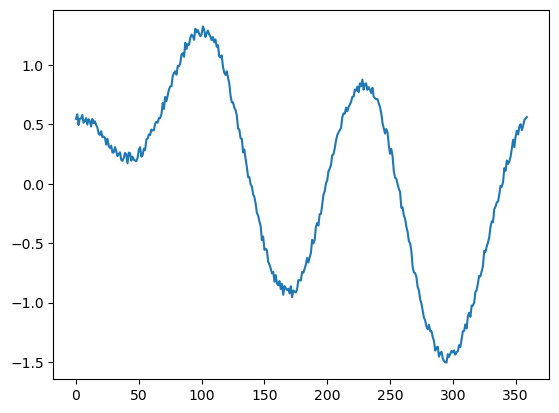

In [2]:
# Construct noisy reference signal
N = 360
t = np.arange(0, N)
a = [0.6, 0.5, 0.75]
w = [0  , 10 , 80  ]
a_noise = 0.1

# Add three signals together
x = np.zeros(t.shape)
for i, (a_i, w_i) in enumerate(zip(a, w)):
    x += a_i * np.sin(2 * np.pi * (i+1) * (t-w_i) / N)
x += a_noise * np.random.random(t.shape)

plt.plot(t, x)

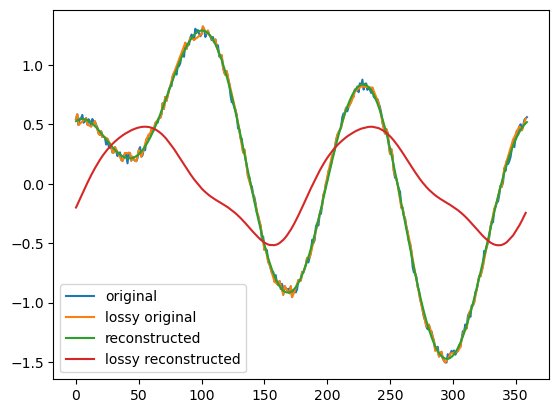

In [3]:
def reconstruct_harmonics(x, t=None, n_harmonics=3):
    if t is None:
        t = np.arange(0, x.shape[0])
        assert(t.shape == x.shape)
    
    # Initial reconstruction is just the mean of the original signal.
    N = t.shape[0]
    x_tfa = np.zeros(N) + np.mean(x)
    
    p = np.arange(1, n_harmonics+1)
    
    # Compute amplitudes for each harmonic
    a = np.fromiter(map(
        lambda p_i: 2 * np.sum(x * np.cos(2 * np.pi * t * p_i / N)) / N,
        p
    ), dtype='float')
    b = np.fromiter(map(
        lambda p_i: 2 * np.sum(x * np.sin(2 * np.pi * t * p_i / N)) / N, 
        p
    ), dtype='float')
    
    # Combine amplitudes into one function
    R = np.sqrt(a ** 2 + b ** 2)
    phi = np.arctan2(-b , a)
    w = 2 * np.pi * p / N
    
    x_tfa = np.mean(x) + np.sum(R * np.cos(np.add(np.outer(w, t).T, phi)), axis=1)
    
    return x_tfa, np.array([R, phi, w])

# Reconstruction of full noisy signal
full_tfa, harmonics = reconstruct_harmonics(x, t)

# Reconstruction when signal is lossy
prop_loss = 0.5
sample = np.random.choice(t, int((1 - prop_loss) * t.shape[0]), replace=False)
sample.sort()
t_lossy = t[sample]
x_lossy = x[sample]

lossy_tfa, lossy_harmonics = reconstruct_harmonics(x_lossy, t_lossy)

# Compare
plt.plot(t, x, label="original")
plt.plot(t_lossy, x_lossy, label="lossy original")
plt.plot(t, full_tfa, label="reconstructed")
plt.plot(t_lossy, lossy_tfa, label="lossy reconstructed")
plt.legend()

Despite the lossy and original signals being very similar, the lossy reconstruction smooths the output. What if we gap fill?

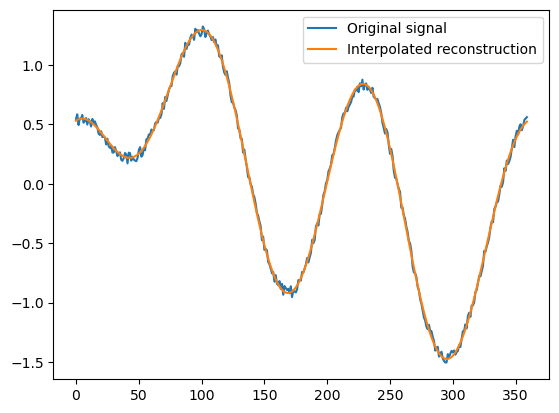

In [4]:
# Linear interpolation between gaps
x_interp = np.interp(t, t_lossy, x_lossy)

interp_tfa, interp_harmonics = reconstruct_harmonics(x_interp, t)

plt.plot(t, x, label="Original signal")
plt.plot(t, interp_tfa, label="Interpolated reconstruction")
#plt.plot(t, full_tfa, label="Full reconstruction")
plt.legend()
plt.show()

Now the reconstruction is very good, and we can see that the underlying harmonics are similar between the interpolated and full versions.

In [5]:
interp_harmonics

array([[ 0.60212417,  0.50232745,  0.75206168],
       [-1.57288802, -1.91720788,  0.52257421],
       [ 0.01745329,  0.03490659,  0.05235988]])

In [6]:
harmonics

array([[ 0.60069282,  0.50009101,  0.75040008],
       [-1.57739441, -1.91810241,  0.51971523],
       [ 0.01745329,  0.03490659,  0.05235988]])